In [3]:
conda install pandas

^C

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os, cv2, shutil, random
import json
import warnings
warnings.simplefilter('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
from tqdm import tqdm
from skimage import io
from PIL import Image
from matplotlib import pyplot as plt
%matplotlib inline

# Shop The Look - Dataset

- This is a dataset taken from ==> Wang-Cheng Kang, Eric Kim, Jure Leskovec, Charles Rosenberg, Julian McAuley (2019). Complete the Look: Scene-based Complementary Product Recommendation. In Proceedings of IEEE Conference on Computer Vision and Pattern Recognition (CVPR'19). [Reference](https://arxiv.org/pdf/1812.01748.pdf)
- It provides the two datasets for fashion and home respectively. Each dataset contains the scene-product pairs in the following format:

- [Github Repo](https://github.com/kang205/STL-Dataset) 

- Example (fashion.json):

``
{
    "product": "0027e30879ce3d87f82f699f148bff7e", 
    "scene": "cdab9160072dd1800038227960ff6467", 
    "bbox": [
        0.434097, 
        0.859363, 
        0.560254, 
        1.0
    ]
}
``

In [3]:
stl_dataset = "D:\MMJ\jupyter\Shop-The-Look\STL-Dataset"
files = [os.path.join(stl_dataset, x) for x in os.listdir(stl_dataset) if x.endswith(".json")]

In [4]:
with open(files[0], "r") as f:
    categories = json.load(f)

In [5]:
# Reference: https://github.com/kang205/STL-Dataset
def convert_to_url(signature):
    """
    Convert Image signatures/ids to urls
    """
    prefix = 'http://i.pinimg.com/400x/%s/%s/%s/%s.jpg'
    return prefix % (signature[0:2], signature[2:4], signature[4:6], signature)

def categorize(x):
    """
    Categorize products into 3 broad categories - Topwear, Bottomwear and Footwear
    """
    if x == 'Shoes':
        return 'footwear'
    elif x in ['Clothing|Pants', 'Clothing|Shorts', 'Clothing|Skirts']:
        return 'bottomwear'
    else:
        return 'topwear'

In [6]:
data = [json.loads(line) for line in open(files[1], 'r')]
data = pd.DataFrame(data)
data['category'] = data['product'].apply(lambda x: categories[x].replace('Apparel & Accessories|', ''))
data = data[data['category'].apply(lambda x: True if ('Clothing' in x) or ('Shoes' in x) else False)]
data = data[data['category'].apply(lambda x: True if ('Sunglasses' not in x) else False)]
data['category'] = data['category'].apply(lambda x: categorize(x))
data['product'] = data['product'].apply(lambda x: convert_to_url(x))
data['scene'] = data['scene'].apply(lambda x: convert_to_url(x))
data['XMIN'] = data['bbox'].apply(lambda x: x[0])
data['YMIN'] = data['bbox'].apply(lambda x: x[1])
data['XMAX'] = data['bbox'].apply(lambda x: x[2])
data['YMAX'] = data['bbox'].apply(lambda x: x[3])
data = data.drop(["bbox"], axis=1)
print("Total Pairs", data.shape[0])
data.head()

Total Pairs 58364


product  \
0  http://i.pinimg.com/400x/00/27/e3/0027e30879ce...   
1  http://i.pinimg.com/400x/00/27/e3/0027e30879ce...   
2  http://i.pinimg.com/400x/00/27/e3/0027e30879ce...   
3  http://i.pinimg.com/400x/00/27/e3/0027e30879ce...   
5  http://i.pinimg.com/400x/00/f9/27/00f9272f652f...   

                                               scene    category      XMIN  \
0  http://i.pinimg.com/400x/cd/ab/91/cdab9160072d...    footwear  0.434097   
1  http://i.pinimg.com/400x/14/f5/93/14f59334af45...    footwear  0.175269   
2  http://i.pinimg.com/400x/e7/d3/2d/e7d32df9f45b...    footwear  0.588666   
3  http://i.pinimg.com/400x/c0/be/58/c0be585ed21b...    footwear  0.276699   
5  http://i.pinimg.com/400x/b6/9e/7f/b69e7fd5c674...  bottomwear  0.319045   

       YMIN      XMAX      YMAX  
0  0.859363  0.560254  1.000000  
1  0.527773  0.621485  0.924899  
2  0.638503  0.750647  0.761368  
3  0.757741  0.400485  0.876138  
5  0.409877  0.724975  0.865827

In [7]:
print("Number of Unique Products:\t", data["product"].nunique())
print("Number of Unique Scenes:\t", data["scene"].nunique())

Number of Unique Products:	 31249
Number of Unique Scenes:	 25799


In [16]:
data.category

0          footwear
1          footwear
2          footwear
3          footwear
5        bottomwear
            ...    
72192    bottomwear
72193       topwear
72194       topwear
72196      footwear
72197       topwear
Name: category, Length: 58364, dtype: object

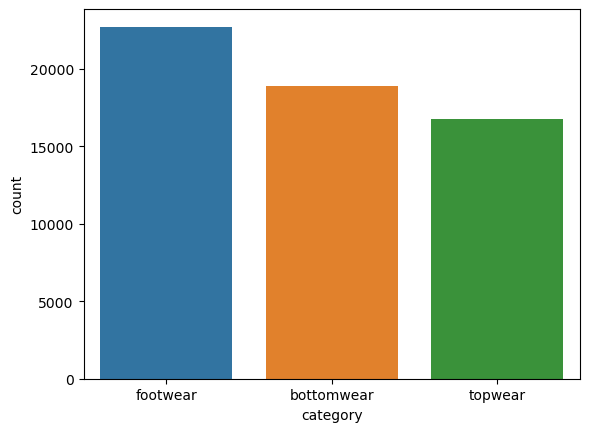

In [18]:
sns.countplot(x = data.category)
plt.show()

In [8]:
topwear = data[data['category'] == 'topwear'].reset_index(drop=True)
bottomwear = data[data['category'] == 'bottomwear'].reset_index(drop=True)
footwear = data[data['category'] == 'footwear'].reset_index(drop=True)

In [9]:
def download_images(dataframe, target_folder):  
    """
    Download images by using the URL and save it locally.
    """
    embeddings_dir = "embeddings_train_data"
    data = list()
    if not os.path.exists(embeddings_dir):
        os.mkdir(embeddings_dir)
    for i, row in tqdm(dataframe.iterrows(), total=dataframe.shape[0]):
        try:
            product_url, product_name = row["product"], row["product"].split("/")[-1]
            scene_url, scene_name = row["scene"], row["scene"].split("/")[-1]
            target_dir = os.path.join(embeddings_dir, target_folder)
            if not os.path.exists(target_dir):
                os.mkdir(target_dir)
                os.mkdir(os.path.join(target_dir, "anchor"))
                os.mkdir(os.path.join(target_dir, "positive"))
            if not os.path.isfile(os.path.join(target_dir, "anchor", product_name)):
                product = Image.fromarray(io.imread(product_url))
                product.save(os.path.join(target_dir, "anchor", product_name))
            if not os.path.isfile(os.path.join(target_dir, "positive", scene_name)):
                scene = io.imread(scene_url)
                XMIN, YMIN, XMAX, YMAX = int(scene.shape[1] * row['XMIN']), int(scene.shape[0] * row['YMIN']), int(scene.shape[1] * row['XMAX']), int(scene.shape[0] * row['YMAX']) 
                scene = Image.fromarray(scene[YMIN:YMAX, XMIN:XMAX])
                scene.save(os.path.join(target_dir, "positive", scene_name))
            data.append((os.path.join(target_dir, "anchor", product_name), os.path.join(target_dir, "positive", scene_name)))
        except Exception as e:
            print(f"Error: {e}")
            continue
    return data

def create_negative(List, positive):
    """
    Select a random image from the same category that will act as negative samples.
    """
    negative = random.choice(List)
    if negative != positive:
        return negative
    else:
        create_negative(List, positive)
        
def plot_samples(dataframe, size=4, random_state=4):
    """
    Plot Anchor, Positive and Negative images in a row for a given batch of images.
    """
    for _, row in dataframe.sample(n=size, random_state=random_state).iterrows():
        anchor, positive, negative = row["anchor"], row["positive"], row["negative"] 
        anchor, positive, negative = io.imread(anchor), io.imread(positive), io.imread(negative)
        plt.figure(figsize=(16,9))
        plt.subplot(131)
        plt.imshow(anchor)
        plt.axis("off"); plt.title("Anchor")
        plt.subplot(132)
        plt.imshow(positive)
        plt.axis("off"); plt.title("Positive")
        plt.subplot(133)
        plt.imshow(negative)
        plt.axis("off"); plt.title("Negative")
        plt.show() 

## Topwear

In [10]:
top_pairs = download_images(topwear, "topwear")

 37%|███████████████████████████▋                                               | 6185/16745 [19:22<1:54:48,  1.53it/s]

Error: HTTP Error 403: Forbidden


 40%|██████████████████████████████▎                                            | 6779/16745 [23:57<1:21:56,  2.03it/s]

Error: HTTP Error 403: Forbidden


 55%|██████████████████████████████████████████▍                                  | 9234/16745 [41:16<59:26,  2.11it/s]

Error: HTTP Error 403: Forbidden


100%|██████████████████████████████████████████████████████████████████████████| 16745/16745 [1:36:25<00:00,  2.89it/s]


In [11]:
top_pairs_csv = pd.DataFrame(top_pairs, columns=["anchor", "positive"])
top_pairs_csv["negative"] = top_pairs_csv["positive"].apply(lambda x: create_negative(top_pairs_csv.positive.to_list(), x)) 
print("Total Pairs: ", top_pairs_csv.shape[0])
top_pairs_csv.to_csv("top_pairs.csv", index=False)

Total Pairs:  16742


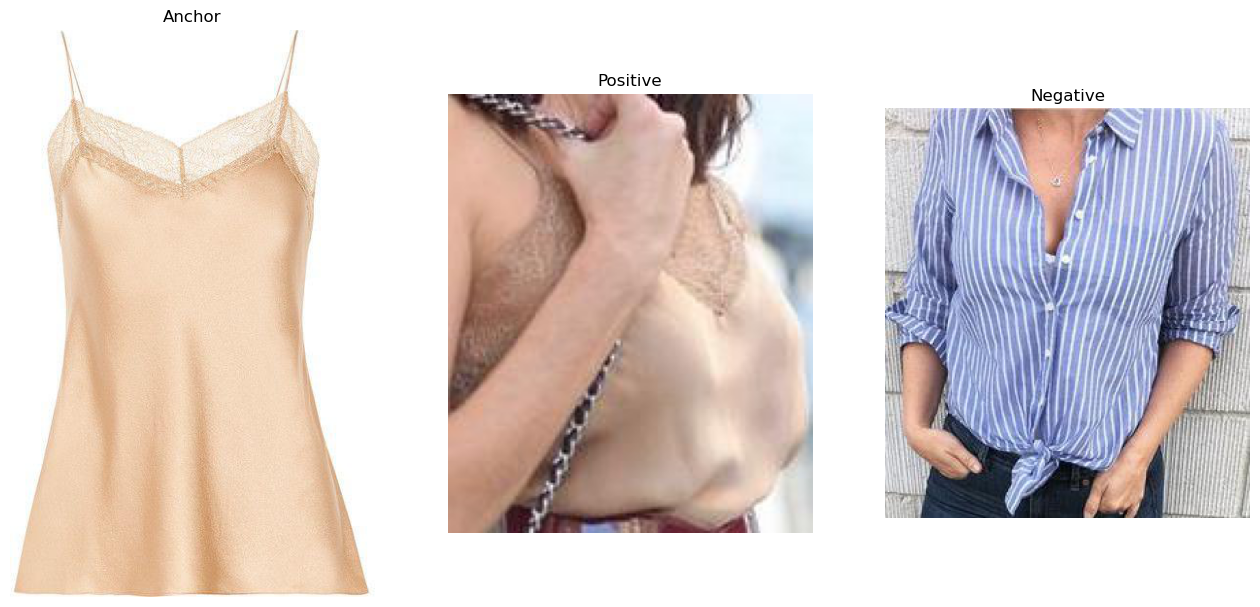

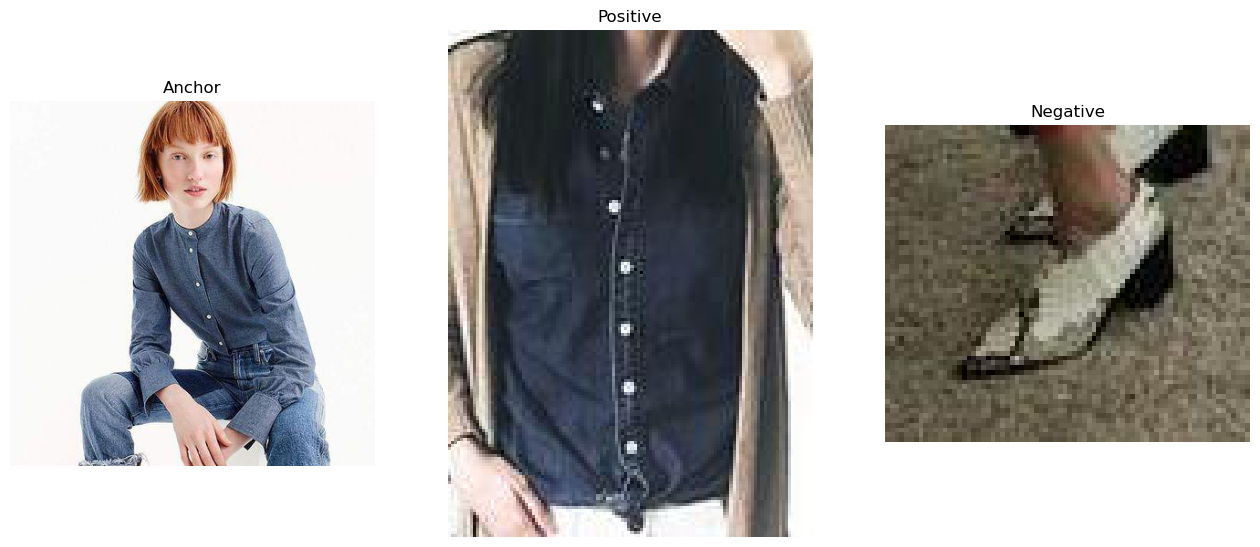

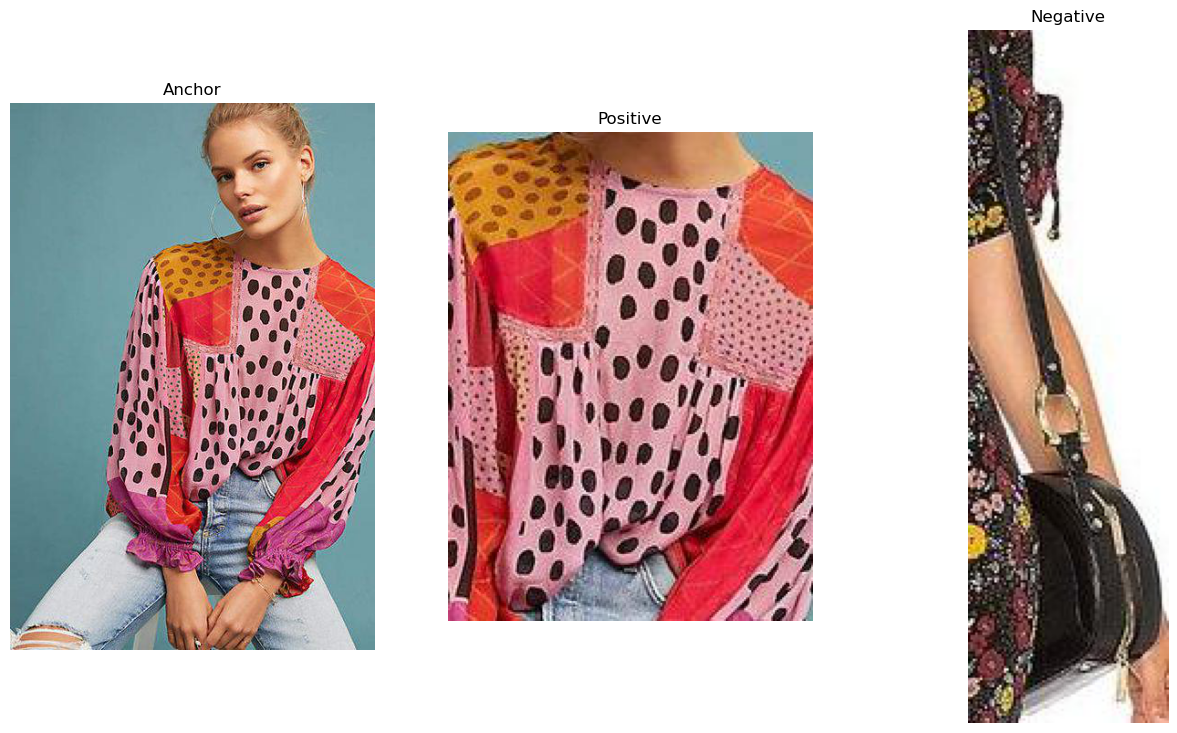

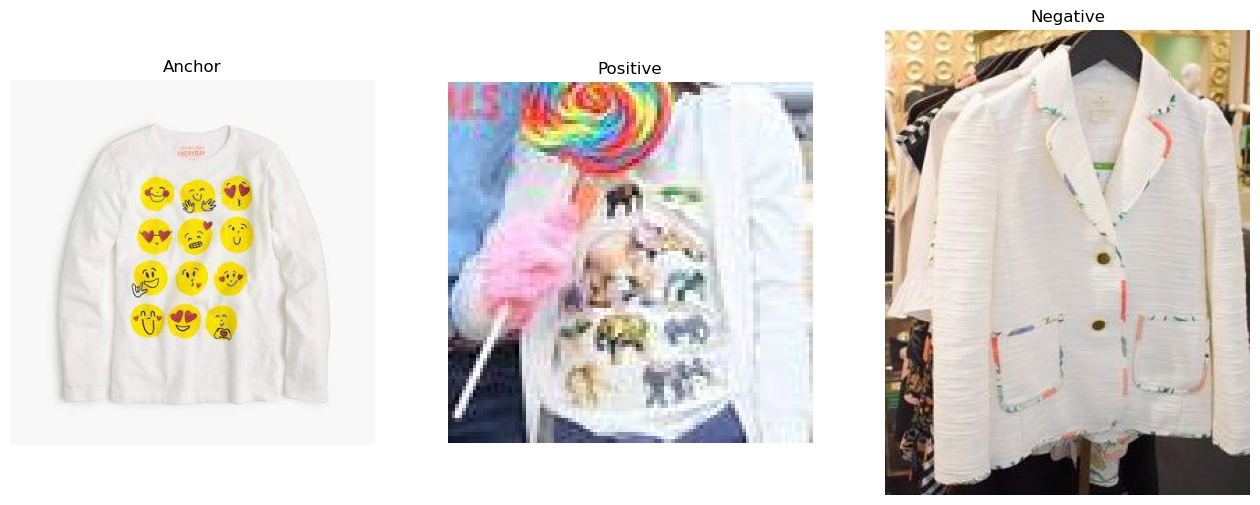

In [12]:
plot_samples(top_pairs_csv)

## Bottomwear

In [239]:
bottom_pairs = download_images(bottomwear, "bottomwear")

100%|██████████████████████████████████████████████████████████████████████████| 18913/18913 [00:15<00:00, 1198.08it/s]


In [258]:
bottom_pairs_csv = pd.DataFrame(bottom_pairs, columns=["anchor", "positive"])
bottom_pairs_csv["negative"] = bottom_pairs_csv["positive"].apply(lambda x: create_negative(bottom_pairs_csv.positive.to_list(), x))
print("Total Pairs: ", bottom_pairs_csv.shape[0])
bottom_pairs_csv.to_csv("bottom_pairs.csv", index=False)

Total Pairs:  18908


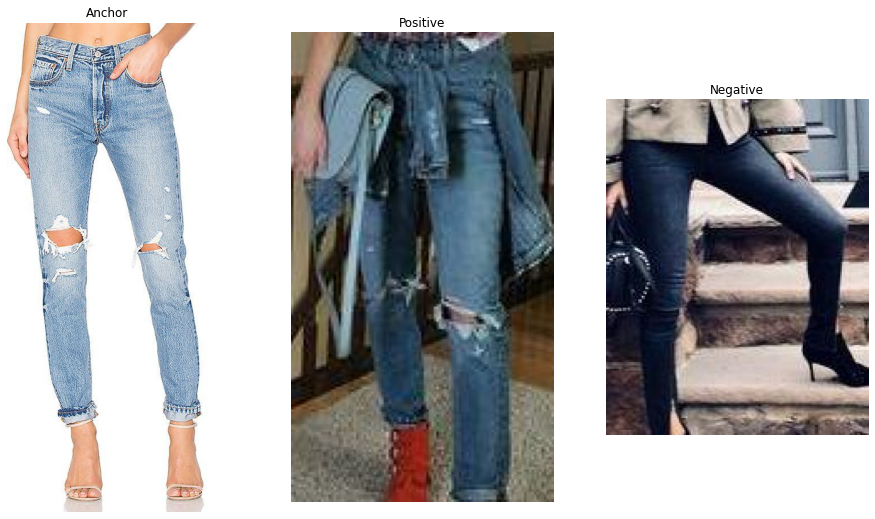

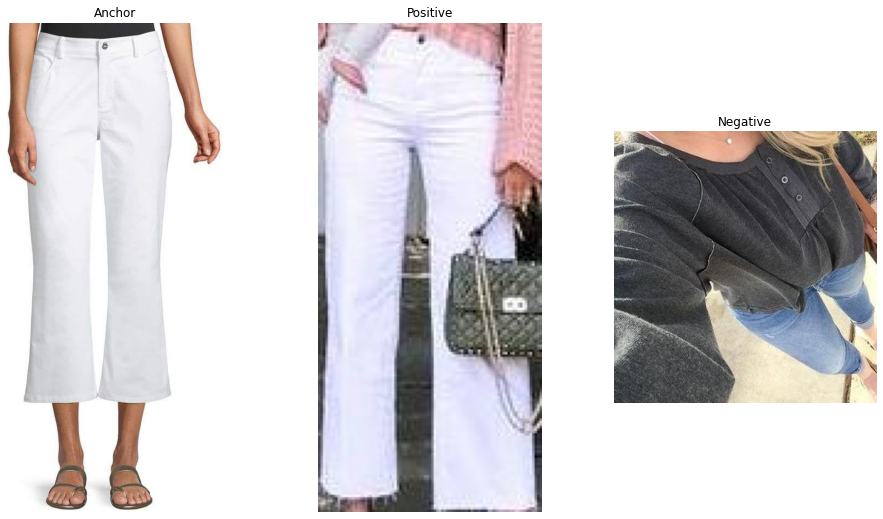

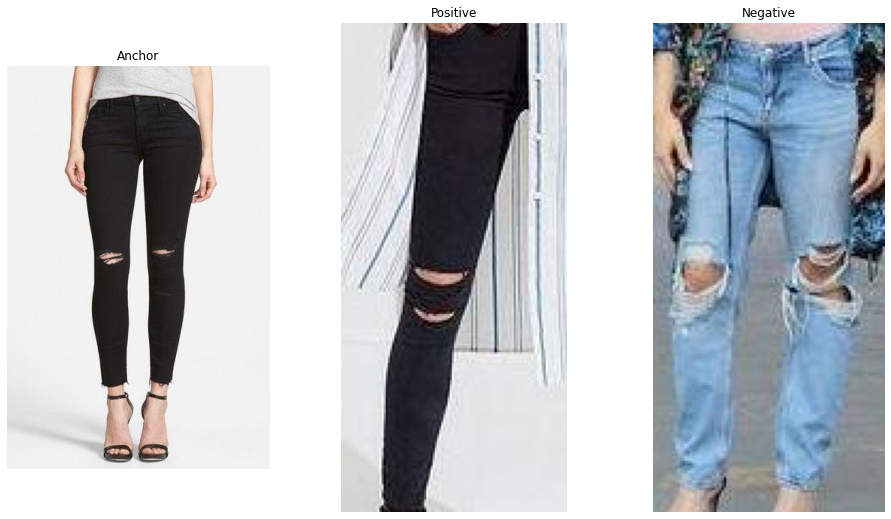

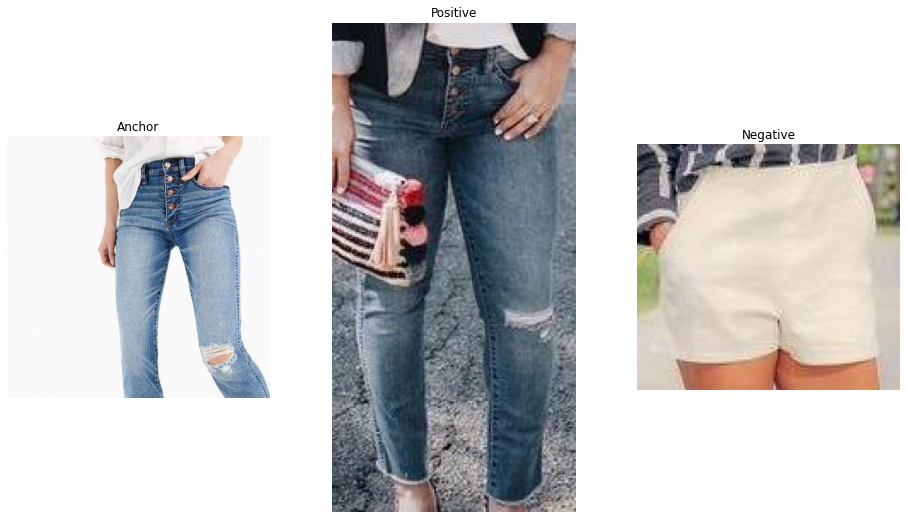

In [276]:
plot_samples(bottom_pairs_csv, random_state=100)

## Footwear

In [241]:
foot_pairs = download_images(footwear, "footwear")

100%|██████████████████████████████████████████████████████████████████████████| 22706/22706 [00:15<00:00, 1429.09it/s]


In [259]:
foot_pairs_csv = pd.DataFrame(foot_pairs, columns=["anchor", "positive"])
foot_pairs_csv["negative"] = foot_pairs_csv["positive"].apply(lambda x: create_negative(foot_pairs_csv.positive.to_list(), x))
print("Total Pairs: ", foot_pairs_csv.shape[0])
foot_pairs_csv.to_csv("foot_pairs.csv", index=False)

Total Pairs:  22702


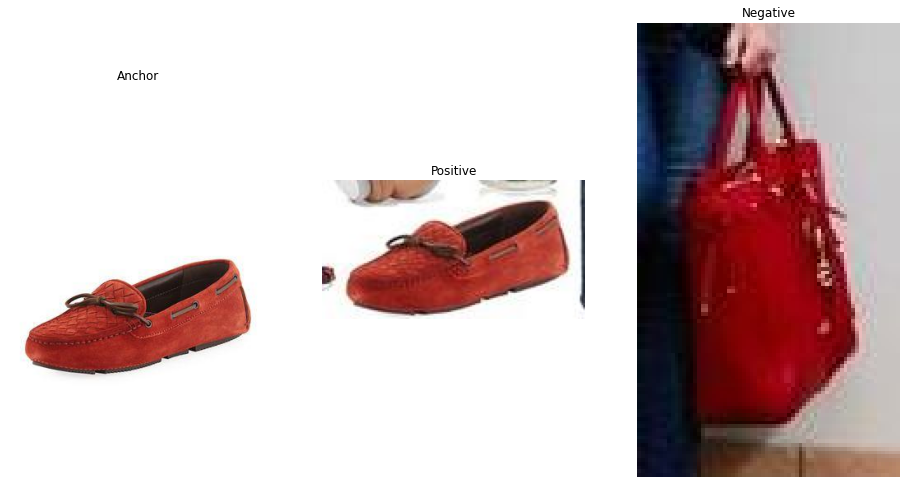

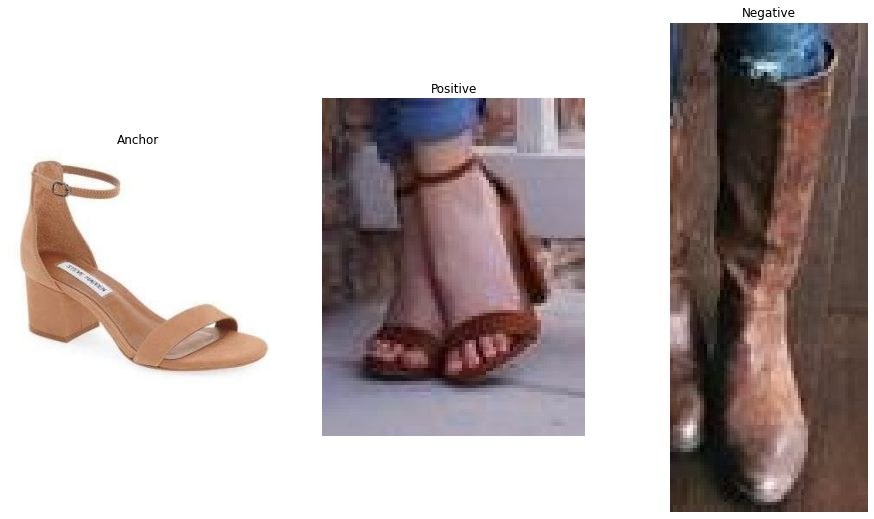

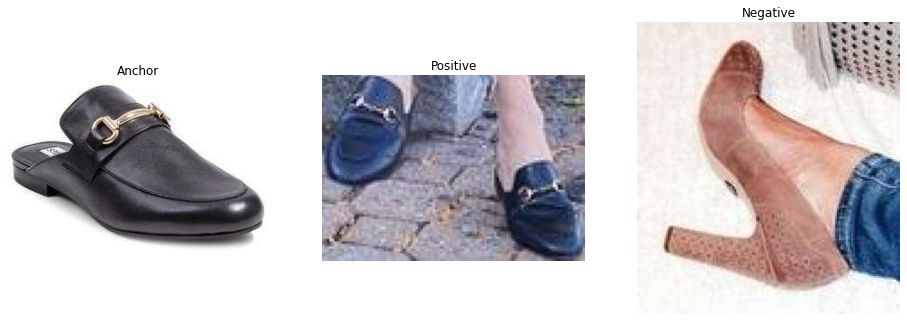

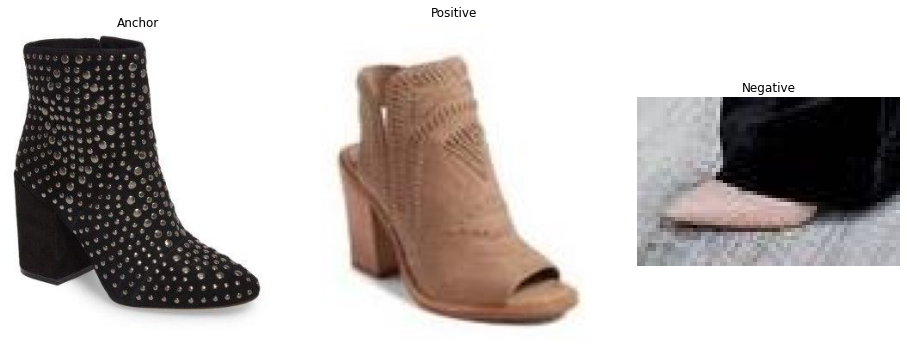

In [284]:
plot_samples(foot_pairs_csv)